In [1]:
import sys
import os.path
sys.path.append(os.path.join('..', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
import matplotlib.pyplot as plt

import filtering
from timer import Timer
import threading as th
import logging

%matplotlib inline

Compiling with /usr/local/bin/clang-omp


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(filename='log.txt',
                    level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)-10s) %(message)s',
                    )

In [3]:
input_image = np.load('image.npz')['image'].astype(np.float32)

#plt.gray()

#plt.imshow(input_image)
#plt.title('original image')

#plt.figure()
#plt.imshow(input_image[1200:1800, 3000:3500])
#plt.title('before - zoom')
input_image.shape

(2404, 9184)

In [147]:
# oct 31 6:20pm

# the problem you're having is because you're slicing so early that the actual median function
# isn't getting the full array to work with. that's why you're getting medians from the 3rd
# row in your first row (the first row shouldn't even be able to see the 3rd row, as it only
# takes the one below it - row2 - and the (nonexistent) one above it, which ends up just being
# a copy of itself). 

# you need to figure out a way to let the cython median function act on the full array, but still
# have each thread only concerned with determining median values for every nth row.

def per_thread_median(A,B,this_thr,evs,I):
    ''' Runs Cython median_3x3() with thread-private offset image slice
    
        Slices start at index start=0...num_threads of tmpA, and are passed in as A.
        
        Each slice waits until the previous iterations of threads controlling
        the thread_num-1, thread_num, and thread_num+1 slices have finished. 
        
        "Finished" is signaled by the Event variable in evs[] for that particular slice on 
        the previous iteration (i-1).
        
        Example: 
            For current iteration i, with thread_index n, where 0 > n > num_threads-1:
            We wait to begin median_3x3 until:
                evs[ n-1, i-1 ] is set to True
                evs[ n  , i-1 ] is set to True
                evs[ n+1, i-1 ] is set to True
        
        Nothing is returned as A is a view on tmpA in the parent function, so modifications
        happen directly to tmpA (which is a copy of the image we're filtering).
    '''
    num_threads = step = evs.shape[0]
    
    for i in range(I):
        #logger.debug('Round {}'.format(i))
        
        '''If this_thr is index 0 or max-thread, wrap-around prev/next thread idx
            Eg. this_thr == 0 --> prev_thread = max-thread idx
        
            NOTE: If only 2 threads, this should still be fine, but two out of the three checks
                  will be for the same Event. 
            Eg. For 2 threads, for thread 0, next_thr = 1, prev_thr = 1, so both will wait for 
                same Event to become true.
        '''    
        prev_thr = this_thr-1 if this_thr-1 >= 0 else num_threads-1
        next_thr = this_thr+1 if this_thr+1 < num_threads else 0
        
        if i: # for i==0 no checking is necessary
            
            #logger.debug('THREAD {} waiting for Events i-1={} to be ready'.format(this_thr,i-1))

            # wait until all nearby threads have finished iteration i-1
            
            evs[ prev_thr, i-1 ].wait()  
            evs[ this_thr, i-1 ].wait() 
            evs[ next_thr, i-1 ].wait() 

        #logger.debug('THREAD {} ready to proceed, i={}\n'.format(this_thr,i))

        filtering.median_3x3(A, B, this_thr, step)
        # swap direction of filtering
        A, B = B, A
        #logger.debug('Results: THREAD {}, i={}'.format(this_thr,i))
        #logger.debug(B)
        #logger.debug('\n\n')
        
        # set Event == True for current thread, current iteration 
        evs[this_thr,i].set()
        
        # lockstep with other threads (don't proceed until all other threads are done for i)
        #for ix in range(num_threads):
        #    evs[ix,i].wait()
        
        
        #logger.debug('THREAD {} complete and Event.set(), i={}'.format(this_thr,i))
            
def py_median_3x3(image, iterations=10, num_threads=1):
    ''' repeatedly filter with a 3x3 median '''
    tmpA = image.copy()
    #tmpA = tmpA[0:4,0:4].copy()
    tmpB = np.empty_like(tmpA)

    # initialize Events array, shape: [num_threads x iterations]
    events = np.empty( (num_threads, iterations), dtype=th._Event )
    
    # populate Events array
    for i in xrange(num_threads):
        events[i,:] = [th.Event() for _ in xrange(iterations)]   
    
    # initialize threads array, shape: [num_threads]
    threads = np.empty(num_threads,dtype=th.Thread)

    # populate threads array
    # each thread starts per_thread_median() with args: slice tmpA, slice tmpB, thread id, events array, num iterations
    for start in range(num_threads):
        threads[start] = th.Thread(name='t{}'.format(start), 
                                   target=per_thread_median, 
                                   args=(tmpA,
                                         tmpB,
                                         start,
                                         events,
                                         iterations
                                        )
                                  )
        threads[start].start()
    
    # reunite threads into master, use .join() to make sure all threads have completed
    for ix in range(num_threads):
        threads[ix].join()
        
    #logger.debug('END FUNCTION\n\n')
    return tmpA

In [92]:
def numpy_median(image, iterations=10):
    ''' filter using numpy '''
    for i in range(iterations):
        padded = np.pad(image, 1, mode='edge')
        stacked = np.dstack((padded[:-2,  :-2], padded[:-2,  1:-1], padded[:-2,  2:],
                             padded[1:-1, :-2], padded[1:-1, 1:-1], padded[1:-1, 2:],
                             padded[2:,   :-2], padded[2:,   1:-1], padded[2:,   2:]))
        image = np.median(stacked, axis=2)

    return image

In [148]:
from_cython = py_median_3x3(input_image, 2, 4)
from_numpy = numpy_median(input_image, 2)
assert np.all(from_cython == from_numpy)
print "CYTHON == NUMPY"

CYTHON == NUMPY


1 THREADS: 3.78619194031 seconds for 10 filter passes.

2 THREADS: 1.85429286957 seconds for 10 filter passes.

4 THREADS: 2.05896019936 seconds for 10 filter passes.



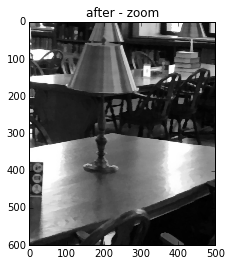

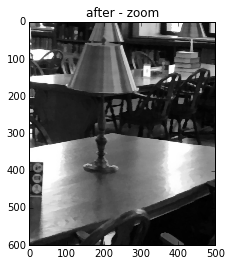

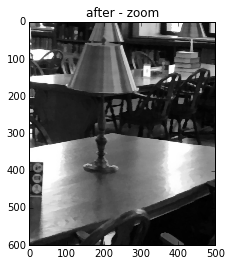

In [150]:
for n_threads in [1,2,4]:
    with Timer() as t:
        new_image = py_median_3x3(input_image, 10, n_threads)

    plt.gray()
    plt.figure()
    plt.imshow(new_image[1200:1800, 3000:3500])
    plt.title('after - zoom')

    print("{} THREADS: {} seconds for 10 filter passes.".format(n_threads,t.interval))
    print
    #plt.show()

In [142]:
print "cython"
print from_cython[0,:]
print
print "numpy"
print from_numpy[0,:]
print np.where(from_cython[0,:] == from_numpy[0,:])[0].shape[0]
print from_cython[0,:].shape[0]
np.where(from_cython[0,:] == from_numpy[0,:])[0].shape[0]/float(from_cython[0,:].shape[0])

cython
[ 159.25239563  159.25239563  156.89360046 ...,  152.10049438  150.10069275
  150.10069275]

numpy
[ 159.25239563  159.25239563  156.89360046 ...,  152.10049438  150.10069275
  150.10069275]
9184
9184


1.0